# **2 - Semantic Segmentation**

## Imports

In [189]:
from torch import nn, optim
from PIL import Image
import torch
import torchvision
import random
import shutil
import cv2
import os
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

## UNet

In [ ]:
class UNet(nn.Module):
  def __init__(self, encoder_channels=(3,64,128,256,512,1024), decoder_channels=(1024, 512, 256, 128, 64), num_class=256):
      super().__init__()
      # Encoder Part:
      self.encoder_size = len(encoder_channels)
      self.encoder_layers = nn.ModuleList()
      for i in range(self.encoder_size-1):
        in_channel = encoder_channels[i]
        out_channel = encoder_channels[i+1]
        self.encoder_layers.append(nn.Conv2d(in_channel, out_channel, 3))
        self.encoder_layers.append(nn.ReLU())
        self.encoder_layers.append(nn.Conv2d(out_channel, out_channel, 3))
      self.pool = nn.MaxPool2d(2)

      # Decoder Part:
      self.decoder_size = len(decoder_channels)
      self.decoder_layers = nn.ModuleList()
      self.up_samplers = nn.ModuleList()
      for i in range(self.decoder_size-1):
        in_channel = decoder_channels[i]
        out_channel = decoder_channels[i+1]
        self.decoder_layers.append(nn.Conv2d(in_channel, out_channel, 3))
        self.decoder_layers.append(nn.ReLU())
        self.decoder_layers.append(nn.Conv2d(out_channel, out_channel, 3))
        self.up_samplers.append(nn.ConvTranspose2d(in_channel, out_channel, 2, 2))
        # self.up_samplers.append(nn.Upsample(scale_factor=2, mode='nearest'))

      
      # Final Part:
      self.final_layer = nn.Conv2d(decoder_channels[-1], num_class, 1)

  def crop(self, encoder_out, decoder_in):
    _, _, h, w = decoder_in.shape
    cropped = torchvision.transforms.CenterCrop([h, w])(encoder_out)
    return cropped
      
  def encode(self, x):
    last_outs = []
    for i in range(self.encoder_size - 1):
      x = self.encoder_layers[i*3](x)
      x = self.encoder_layers[i*3+1](x)
      x = self.encoder_layers[i*3+2](x)
      last_outs.append(x)
      x = self.pool(x)
    return last_outs
  
  def decode(self, x, encoder_out):
    for i in range(self.decoder_size - 1):
      x = self.up_samplers[i](x)
      encoder_out_cropped = self.crop(encoder_out[i], x)
      x = torch.cat([x, encoder_out_cropped], dim=1)
      x = self.decoder_layers[i*3](x)
      x = self.decoder_layers[i*3+1](x)
      x = self.decoder_layers[i*3+2](x)
    return x

  def forward(self, x):
      encoder_out = self.encode(x)
      decoder_out = self.decode(encoder_out[::-1][0], encoder_out[::-1][1:])
      out = self.final_layer(decoder_out)
      return out

## Train and Test

In [ ]:
def train(model, train_loader, test_loader, epochs_num, optimizer, loss_function, train_size, test_size):
  epochs_train_loss = []
  epochs_test_loss = []
  for i, epoch in tqdm(enumerate(range(1, epochs_num+1))):
    batches_train_loss = []
    batches_train_predictions = []
    batches_train_targets = []

    for index, data in enumerate(train_loader):
      features, targets = data
      features = features.float() 
      targets = targets.float()
      features, targets = features.cuda(), targets.cuda()
      optimizer.zero_grad()
      output = model(features)
      loss = loss_function(output, targets.long().squeeze(1))

      loss.backward()
      optimizer.step()

      batches_train_loss.append(loss.item())

      if (index+1) % 2000==0:
          print("Batch number {} is finished!".format(index+1))
    
    batches_test_loss = test(model, test_loader, optimizer, loss_function)
    epochs_train_loss.append(np.sum(batches_train_loss)/train_size)

    epochs_test_loss.append(np.sum(batches_test_loss)/test_size)

    print('Epoch {} is finished!'.format(epoch))
  return epochs_train_loss, epochs_test_loss

In [ ]:
def test(model, test_loader, optimizer, loss_function):
  batches_test_loss = []
  with torch.no_grad():
    for features, target in test_loader:
      features, target = features.cuda(), target.cuda()
      features = features.float() 
      target = target.float()
      output = model(features)
      loss = loss_function(output, target.long().squeeze(1)).item()
      batches_test_loss.append(loss)
    
  return batches_test_loss

## Load Data

In [ ]:
!wget https://s3.amazonaws.com/fast-ai-imagelocal/camvid.tgz

--2021-06-08 05:47:46--  https://s3.amazonaws.com/fast-ai-imagelocal/camvid.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.76.46
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.76.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 598913237 (571M) [application/x-tar]
Saving to: ‘camvid.tgz’

camvid.tgz          100%[===================>] 571.17M  52.0MB/s    in 9.1s    

2021-06-08 05:47:55 (63.0 MB/s) - ‘camvid.tgz’ saved [598913237/598913237]



In [ ]:
!tar -xvzf camvid.tgz

In [ ]:
images_path ="/content/camvid/images"
labels_path="/content/camvid/labels"

In [ ]:
# Edit labels 

labels = os.listdir(labels_path)
for label in labels:
    old_label = str(label)
    new_label = label.replace('_P.png','.png')
    print(old_label, new_label)
    os.rename(os.path.join(labels_path,old_label),os.path.join(labels_path,new_label))

In [ ]:
!rm -r /content/camvid/images/.ipynb_checkpoints
!rm -r /content/camvid/images/test.txt

rm: cannot remove '/content/camvid/images/.ipynb_checkpoints': No such file or directory


In [ ]:
images_name = os.listdir(images_path)
images_size = len(images_name)
train_images = random.sample(images_name, int(0.7*images_size))
len(train_images)

490

In [ ]:
test_images = []
for image in images_name:
  if not image in train_images:
    test_images.append(image)
len(test_images)

211

In [ ]:
train_path = '/content/camvid/train'
test_path = '/content/camvid/test'
if os.path.exists(train_path)==False:
    os.mkdir(train_path)
if os.path.exists(test_path)==False:
    os.mkdir(test_path)

In [ ]:
train_images_path = '/content/camvid/train/images'
test_images_path = '/content/camvid/test/images'
if os.path.exists(train_images_path)==False:
    os.mkdir(train_images_path)
if os.path.exists(test_images_path)==False:
    os.mkdir(test_images_path)

In [ ]:
train_labels_path = '/content/camvid/train/labels'
test_labels_path = '/content/camvid/test/labels'
if os.path.exists(train_labels_path)==False:
    os.mkdir(train_labels_path)
if os.path.exists(test_labels_path)==False:
    os.mkdir(test_labels_path)

In [ ]:
for image in train_images:
  shutil.copy(os.path.join(images_path,image), os.path.join(train_images_path,image))
  shutil.copy(os.path.join(labels_path,image), os.path.join(train_labels_path,image))

In [ ]:
for image in test_images:
  shutil.copy(os.path.join(images_path,image), os.path.join(test_images_path,image))
  shutil.copy(os.path.join(labels_path,image), os.path.join(test_labels_path,image))

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, input_dir_path, labels_dir_path):
      self.inputs_names = os.listdir(input_dir_path)
      self.inputs = [os.path.join(input_dir_path, input_name) for input_name in self.inputs_names]
      self.labels = [os.path.join(labels_dir_path, input_name) for input_name in self.inputs_names]
  def __getitem__(self, i):
      image = cv2.imread(self.inputs[i])
      label = cv2.imread(self.labels[i], 0)
      image = cv2.resize(image, (320, 320)).reshape(3, 320, 320)
      label = cv2.resize(label, (132, 132)).reshape(1, 132, 132)
      return image, label
  def __len__(self):
      return len(self.inputs)

In [ ]:
train_dataset = CustomDataset(train_images_path, train_labels_path)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [ ]:
test_dataset = CustomDataset(test_images_path, test_labels_path)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

## Define Model

In [ ]:
torch.cuda.empty_cache()

In [ ]:
import gc
del model
gc.collect()

5068

In [ ]:
model = UNet()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, weight_decay=1e-8)

In [ ]:
model.cuda()

UNet(
  (encoder_layers): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU()
    (11): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
    (12): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU()
    (14): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1))
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (decoder_layers): ModuleList(
    (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
    (3): C

In [ ]:
epochs_train_loss, epochs_test_loss = train(model, train_loader, test_loader, 100, optimizer, criterion, len(train_dataset), len(test_dataset))


0it [00:00, ?it/s]
1it [00:39, 39.47s/it]

Epoch 1 is finished!



2it [01:17, 39.18s/it]

Epoch 2 is finished!



3it [01:56, 39.04s/it]

Epoch 3 is finished!



4it [02:35, 38.96s/it]

Epoch 4 is finished!



5it [03:14, 38.85s/it]

Epoch 5 is finished!



6it [03:52, 38.82s/it]

Epoch 6 is finished!



7it [04:31, 38.77s/it]

Epoch 7 is finished!



8it [05:10, 38.72s/it]

Epoch 8 is finished!



9it [05:48, 38.76s/it]

Epoch 9 is finished!



10it [06:27, 38.74s/it]

Epoch 10 is finished!



11it [07:06, 38.70s/it]

Epoch 11 is finished!



12it [07:44, 38.68s/it]

Epoch 12 is finished!



13it [08:23, 38.69s/it]

Epoch 13 is finished!



14it [09:02, 38.66s/it]

Epoch 14 is finished!



15it [09:40, 38.67s/it]

Epoch 15 is finished!



16it [10:19, 38.67s/it]

Epoch 16 is finished!



17it [10:58, 38.69s/it]

Epoch 17 is finished!



18it [11:36, 38.69s/it]

Epoch 18 is finished!



19it [12:15, 38.68s/it]

Epoch 19 is finished!



20it [12:54, 38.70s/it]

Epoch 20 is finished!



21it [13:33, 38.71s/it]

Epoch 21 is finished!



22it [14:11, 38.70s/it]

Epoch 22 is finished!



23it [14:50, 38.68s/it]

Epoch 23 is finished!



24it [15:29, 38.67s/it]

Epoch 24 is finished!



25it [16:07, 38.66s/it]

Epoch 25 is finished!



26it [16:46, 38.65s/it]

Epoch 26 is finished!



27it [17:25, 38.68s/it]

Epoch 27 is finished!



28it [18:03, 38.67s/it]

Epoch 28 is finished!



29it [18:42, 38.66s/it]

Epoch 29 is finished!



30it [19:21, 38.68s/it]

Epoch 30 is finished!



31it [19:59, 38.66s/it]

Epoch 31 is finished!



32it [20:38, 38.66s/it]

Epoch 32 is finished!



33it [21:16, 38.65s/it]

Epoch 33 is finished!



34it [21:55, 38.67s/it]

Epoch 34 is finished!



35it [22:34, 38.68s/it]

Epoch 35 is finished!



36it [23:13, 38.68s/it]

Epoch 36 is finished!



37it [23:52, 38.79s/it]

Epoch 37 is finished!



38it [24:30, 38.82s/it]

Epoch 38 is finished!



39it [25:09, 38.80s/it]

Epoch 39 is finished!



40it [25:48, 38.81s/it]

Epoch 40 is finished!



41it [26:27, 38.81s/it]

Epoch 41 is finished!



42it [27:06, 38.77s/it]

Epoch 42 is finished!



43it [27:44, 38.77s/it]

Epoch 43 is finished!



44it [28:23, 38.75s/it]

Epoch 44 is finished!



45it [29:02, 38.72s/it]

Epoch 45 is finished!



46it [29:40, 38.69s/it]

Epoch 46 is finished!



47it [30:19, 38.68s/it]

Epoch 47 is finished!



48it [30:58, 38.64s/it]

Epoch 48 is finished!



49it [31:36, 38.64s/it]

Epoch 49 is finished!



50it [32:15, 38.59s/it]

Epoch 50 is finished!



51it [32:53, 38.53s/it]

Epoch 51 is finished!



52it [33:32, 38.52s/it]

Epoch 52 is finished!



53it [34:10, 38.49s/it]

Epoch 53 is finished!



54it [34:48, 38.48s/it]

Epoch 54 is finished!



55it [35:27, 38.48s/it]

Epoch 55 is finished!



56it [36:05, 38.50s/it]

Epoch 56 is finished!



57it [36:44, 38.50s/it]

Epoch 57 is finished!



58it [37:22, 38.49s/it]

Epoch 58 is finished!



59it [38:01, 38.47s/it]

Epoch 59 is finished!



60it [38:39, 38.48s/it]

Epoch 60 is finished!



61it [39:18, 38.49s/it]

Epoch 61 is finished!



62it [39:56, 38.51s/it]

Epoch 62 is finished!



63it [40:35, 38.55s/it]

Epoch 63 is finished!



64it [41:14, 38.58s/it]

Epoch 64 is finished!



65it [41:52, 38.60s/it]

Epoch 65 is finished!



66it [42:31, 38.59s/it]

Epoch 66 is finished!



67it [43:09, 38.60s/it]

Epoch 67 is finished!



68it [43:48, 38.62s/it]

Epoch 68 is finished!



69it [44:27, 38.61s/it]

Epoch 69 is finished!



70it [45:05, 38.62s/it]

Epoch 70 is finished!



71it [45:44, 38.64s/it]

Epoch 71 is finished!



72it [46:23, 38.64s/it]

Epoch 72 is finished!



73it [47:01, 38.65s/it]

Epoch 73 is finished!



74it [47:40, 38.60s/it]

Epoch 74 is finished!



75it [48:18, 38.59s/it]

Epoch 75 is finished!



76it [48:57, 38.57s/it]

Epoch 76 is finished!



77it [49:36, 38.58s/it]

Epoch 77 is finished!



78it [50:14, 38.60s/it]

Epoch 78 is finished!



79it [50:53, 38.56s/it]

Epoch 79 is finished!



80it [51:31, 38.57s/it]

Epoch 80 is finished!



81it [52:10, 38.59s/it]

Epoch 81 is finished!



82it [52:49, 38.61s/it]

Epoch 82 is finished!



83it [53:27, 38.61s/it]

Epoch 83 is finished!



84it [54:06, 38.60s/it]

Epoch 84 is finished!



85it [54:44, 38.60s/it]

Epoch 85 is finished!



86it [55:23, 38.55s/it]

Epoch 86 is finished!



87it [56:01, 38.54s/it]

Epoch 87 is finished!



88it [56:40, 38.50s/it]

Epoch 88 is finished!



89it [57:18, 38.51s/it]

Epoch 89 is finished!



90it [57:57, 38.48s/it]

Epoch 90 is finished!



91it [58:35, 38.48s/it]

Epoch 91 is finished!


## Result

In [ ]:
def plot_result(epochs_train, epochs_test, epochs_num, title):
  x_axis = range(1, epochs_num+1)
  legends = ['train', 'test']
  x_label = 'Epoch'
  plt.plot(x_axis, epochs_train)
  plt.plot(x_axis, epochs_test)
  plt.title(title)
  plt.xlabel(x_label)
  plt.legend(legends)
  plt.show()

In [ ]:
def predict(model, feature):
  with torch.no_grad():
    feature = feature.cuda()
    feature = feature.float() 
    output = model(feature)    
  return output.argmax(1)

In [224]:
def show_prediction(model, batch_num=1):
  for i, data in enumerate(test_loader):
    features, target = data
    if i>batch_num:
      break
    prediction = np.array(predict(model, features).cpu().data)
    for j in range(len(features)):
      print('Input Image {}-{}'.format(i+1, j+1))
      cv2_imshow(np.array(features[j].reshape(320, 320, 3)))

      print('Target Image {}-{}'.format(i+1, j+1))
      cv2_imshow(np.array(target[j].reshape(132, 132)))

      print('Prediction Image {}-{}'.format(i+1, j+1))
      cv2_imshow(prediction[j].reshape(132, 132))
      # print(prediction)

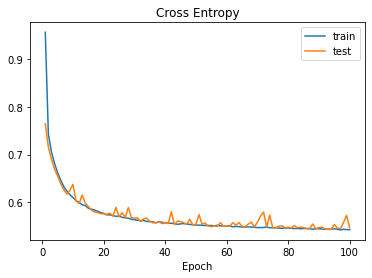

In [182]:
plot_result(epochs_train_loss, epochs_test_loss, 100, "Cross Entropy")

Input Image 1-1


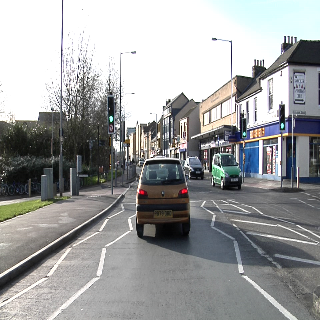

Target Image 1-1


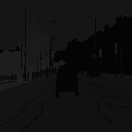

Prediction Image 1-1


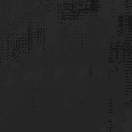

Input Image 1-2


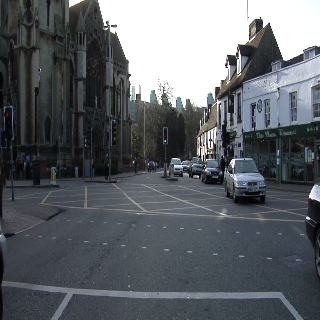

Target Image 1-2


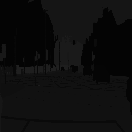

Prediction Image 1-2


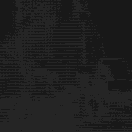

Input Image 1-3


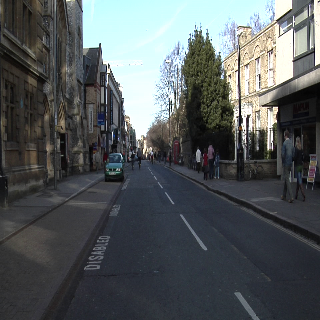

Target Image 1-3


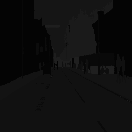

Prediction Image 1-3


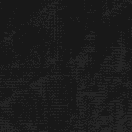

Input Image 1-4


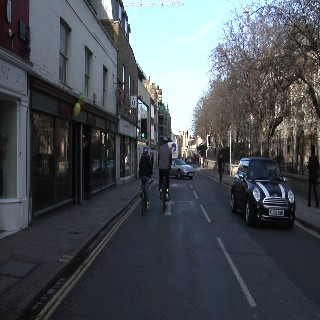

Target Image 1-4


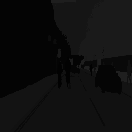

Prediction Image 1-4


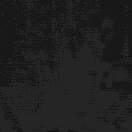

Input Image 2-1


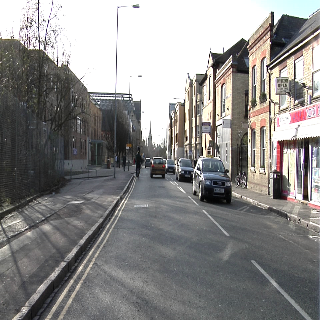

Target Image 2-1


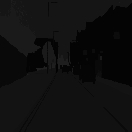

Prediction Image 2-1


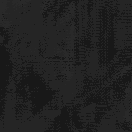

Input Image 2-2


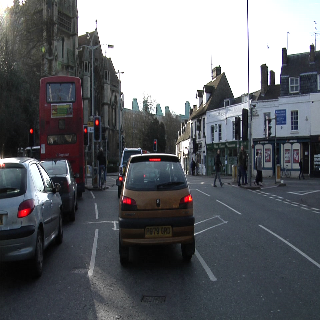

Target Image 2-2


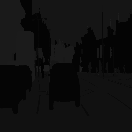

Prediction Image 2-2


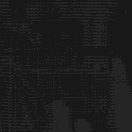

Input Image 2-3


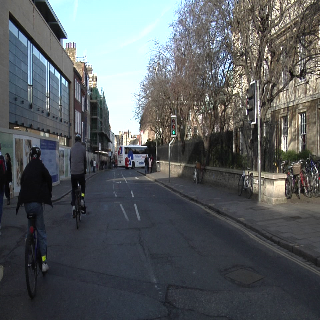

Target Image 2-3


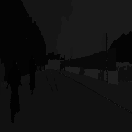

Prediction Image 2-3


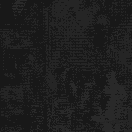

Input Image 2-4


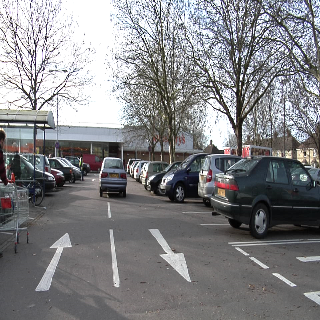

Target Image 2-4


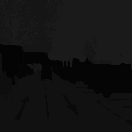

Prediction Image 2-4


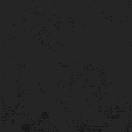

In [218]:
show_prediction(model)

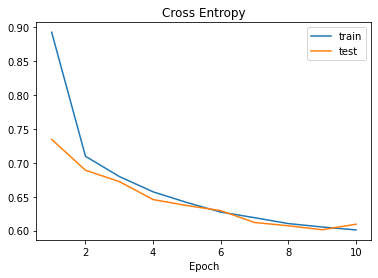

In [ ]:
plot_result(epochs_train_loss, epochs_test_loss, 10, "Cross Entropy")

In [220]:
model2 = UNet()
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.0001, weight_decay=1e-8)
model2.cuda()
epochs_train_loss2, epochs_test_loss2 = train(model2, train_loader, test_loader, 50, optimizer2, criterion2, len(train_dataset), len(test_dataset))



0it [00:00, ?it/s]

1it [00:39, 39.99s/it]

Epoch 1 is finished!




2it [01:19, 39.85s/it]

Epoch 2 is finished!




3it [01:59, 39.77s/it]

Epoch 3 is finished!




4it [02:38, 39.72s/it]

Epoch 4 is finished!




5it [03:18, 39.66s/it]

Epoch 5 is finished!




6it [03:57, 39.59s/it]

Epoch 6 is finished!




7it [04:36, 39.51s/it]

Epoch 7 is finished!




8it [05:16, 39.44s/it]

Epoch 8 is finished!




9it [05:55, 39.38s/it]

Epoch 9 is finished!




10it [06:34, 39.28s/it]

Epoch 10 is finished!




11it [07:13, 39.22s/it]

Epoch 11 is finished!




12it [07:52, 39.20s/it]

Epoch 12 is finished!




13it [08:31, 39.19s/it]

Epoch 13 is finished!




14it [09:11, 39.18s/it]

Epoch 14 is finished!




15it [09:50, 39.20s/it]

Epoch 15 is finished!




16it [10:29, 39.17s/it]

Epoch 16 is finished!




17it [11:08, 39.07s/it]

Epoch 17 is finished!




18it [11:47, 39.05s/it]

Epoch 18 is finished!




19it [12:26, 39.08s/it]

Epoch 19 is finished!




20it [13:05, 39.11s/it]

Epoch 20 is finished!




21it [13:44, 39.15s/it]

Epoch 21 is finished!




22it [14:24, 39.18s/it]

Epoch 22 is finished!




23it [15:02, 39.07s/it]

Epoch 23 is finished!




24it [15:41, 38.91s/it]

Epoch 24 is finished!




25it [16:19, 38.80s/it]

Epoch 25 is finished!




26it [16:58, 38.72s/it]

Epoch 26 is finished!




27it [17:37, 38.67s/it]

Epoch 27 is finished!




28it [18:15, 38.60s/it]

Epoch 28 is finished!




29it [18:54, 38.67s/it]

Epoch 29 is finished!




30it [19:33, 38.96s/it]

Epoch 30 is finished!




31it [20:12, 38.95s/it]

Epoch 31 is finished!




32it [20:51, 38.91s/it]

Epoch 32 is finished!




33it [21:30, 38.87s/it]

Epoch 33 is finished!




34it [22:09, 38.88s/it]

Epoch 34 is finished!




35it [22:48, 38.86s/it]

Epoch 35 is finished!




36it [23:26, 38.84s/it]

Epoch 36 is finished!




37it [24:06, 38.94s/it]

Epoch 37 is finished!




38it [24:45, 38.98s/it]

Epoch 38 is finished!




39it [25:24, 38.91s/it]

Epoch 39 is finished!




40it [26:02, 38.92s/it]

Epoch 40 is finished!




41it [26:41, 38.91s/it]

Epoch 41 is finished!




42it [27:20, 38.95s/it]

Epoch 42 is finished!




43it [27:59, 38.94s/it]

Epoch 43 is finished!




44it [28:38, 38.95s/it]

Epoch 44 is finished!




45it [29:17, 38.94s/it]

Epoch 45 is finished!




46it [29:56, 38.94s/it]

Epoch 46 is finished!




47it [30:35, 38.91s/it]

Epoch 47 is finished!




48it [31:14, 38.89s/it]

Epoch 48 is finished!




49it [31:53, 38.84s/it]

Epoch 49 is finished!




50it [32:31, 39.04s/it]

Epoch 50 is finished!


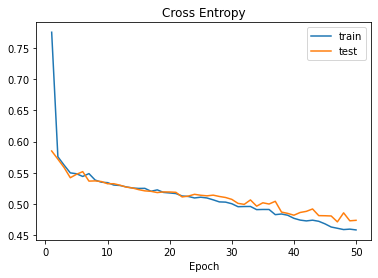

In [221]:
plot_result(epochs_train_loss2, epochs_test_loss2, 50, "Cross Entropy")

Input Image 1-1


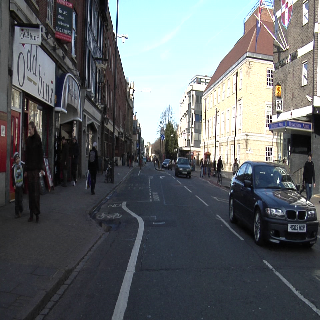

Target Image 1-1


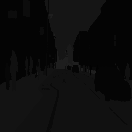

Prediction Image 1-1


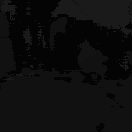

Input Image 1-2


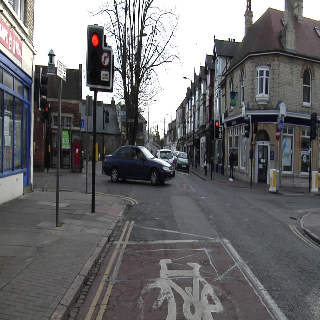

Target Image 1-2


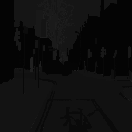

Prediction Image 1-2


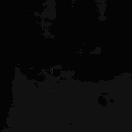

Input Image 1-3


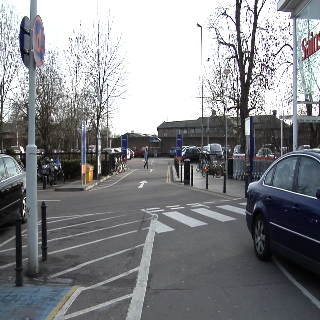

Target Image 1-3


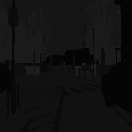

Prediction Image 1-3


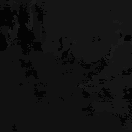

Input Image 1-4


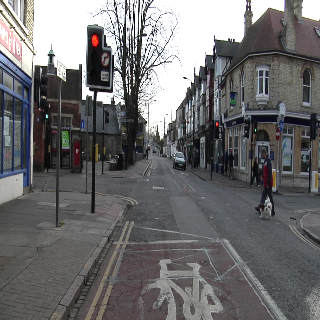

Target Image 1-4


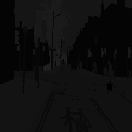

Prediction Image 1-4


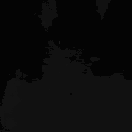

Input Image 2-1


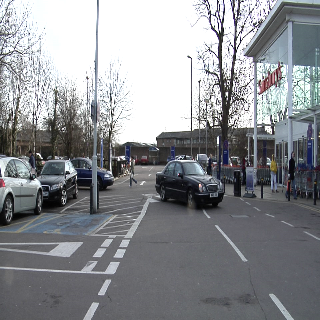

Target Image 2-1


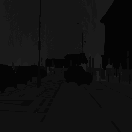

Prediction Image 2-1


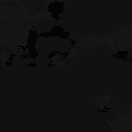

Input Image 2-2


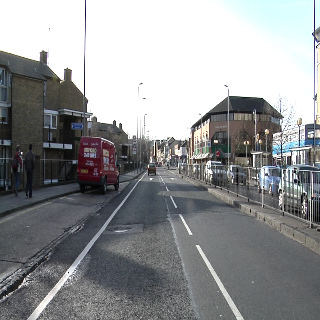

Target Image 2-2


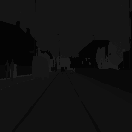

Prediction Image 2-2


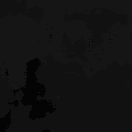

Input Image 2-3


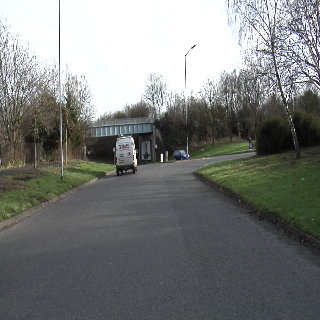

Target Image 2-3


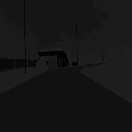

Prediction Image 2-3


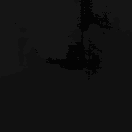

Input Image 2-4


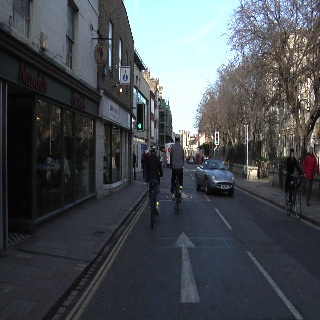

Target Image 2-4


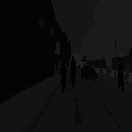

Prediction Image 2-4


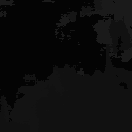

In [225]:
show_prediction(model2)